In [30]:
import numpy as np
import matplotlib.pyplot as plt
import qrcode
from PIL import Image

In [31]:

def generate_watermark(data,secret,quant=16,size=(100,100),rprop=100):
    dist  = [0 if i==0 else int(i*256/quant)-1 for i in range(quant+1)]
    np.random.seed(abs(hash(data+secret))%2**32)
    p=np.random.choice([i for i in range(rprop)],size = 17)
    p=p/p.sum()
    watermark = np.random.choice(dist,size=size,p=p)
    return watermark.astype('uint8')

In [32]:
SECRET="rahasia"
def make_secureQR(data:str,secret:str=SECRET,border=8,**kwargs)-> np.ndarray:
    img = qrcode.make(data,version=3,error_correction=qrcode.constants.ERROR_CORRECT_H)
    img = np.asanyarray(img).astype('uint8')*255
    watermark = generate_watermark(data,secret,**kwargs)

    # add border watermark 8
    length = watermark.shape[0] + border
    loc = img.shape[0]//2 - length//2
    wm = np.ones((length,length),dtype='uint8')*255
    wm[4:-4,4:-4] = watermark
    img[loc:loc+length,loc:loc+length]=wm
    return img

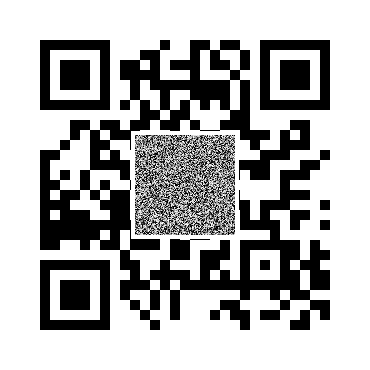

In [33]:
img = make_secureQR("halo0001",quant=16)
im = Image.fromarray(img)
im

In [38]:
# generate batch of images
import pathlib
import numpy as np
from pathlib import Path

path =Path("watermark")

rows = []
for i in range(100): 
    print(i,end=' ')
    for j in range(2):
        col = []
        for k in range(5):
            img = make_secureQR(f'{i+1:03}',quant=16)
            col.append(img)
        rows.append(np.hstack(col))
    if (i+1)%4 ==0:
        rows.append(np.ones((10,rows[0].shape[1]),dtype='uint8'))
        grid = np.vstack(rows)

        Image.fromarray(grid).save(path/f"{i-2:03}_{i+1}.pdf")
        rows=[]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [37]:
grid.shape

(2970, 1850)

In [11]:
from PIL import Image
im = Image.fromarray(img)
im.save('qr1.pdf')

In [15]:
# 1 inch = 25.4 mm
img.shape[0]

370

(array([2084.,  948.,  838., 1180.,    0.,  391.,  999.,  243.,   48.,
         626.,    0.,    8., 1310.,  148.,  723.,  454.]),
 array([0.    , 0.0625, 0.125 , 0.1875, 0.25  , 0.3125, 0.375 , 0.4375,
        0.5   , 0.5625, 0.625 , 0.6875, 0.75  , 0.8125, 0.875 , 0.9375,
        1.    ]),
 <BarContainer object of 16 artists>)

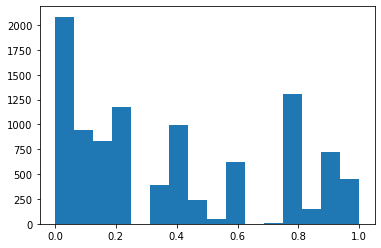

In [92]:
plt.hist(watermark.ravel()/watermark.max(),bins=16)